<a href="https://www.kaggle.com/code/ivanstabile/bitcoin-modello-lstm-ivan-stabile?scriptVersionId=242595149" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 1. Importo le librerie

In [1]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score, mean_absolute_percentage_error
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

# 2. Carico il dataset

In [2]:
df = pd.read_csv("/kaggle/input/bitcoin-usd/bitcoin-usd.csv")
vix = pd.read_csv("/kaggle/input/volatility-index/vix.csv")
gold = pd.read_csv("/kaggle/input/gold-price/gold-price.csv")
oil = pd.read_csv("/kaggle/input/oil-price/oil-price.csv")
dowjones = pd.read_csv("/kaggle/input/indexes/dow-jones-index.csv")
sp500 = pd.read_csv("/kaggle/input/indexes/sp500-index.csv")
nasdaq = pd.read_csv("/kaggle/input/indexes/nasdaq-index.csv")
ftse = pd.read_csv("/kaggle/input/indexes/ftse-index.csv")
usdollar = pd.read_csv("/kaggle/input/indexes/usdollar-index.csv")
cpi = pd.read_csv("/kaggle/input/cpi-index/cpi.csv")
btc_mc = pd.read_csv("/kaggle/input/btc-marketcap/btc-data1.csv")
interest_rate = pd.read_csv("/kaggle/input/interest-rate/interest-rate.csv")

## 2.1 Vix Index

In [3]:
vix["DATE"] = pd.to_datetime(vix['DATE'])
vix = vix[(vix['DATE'] >= '2014-08-01') & (vix['DATE'] <= '2024-06-24')]
vix = vix.copy()
vix['VIXCLS'] = pd.to_numeric(vix['VIXCLS'],errors = 'coerce')
vix.columns = ['Date', 'vix_index']
vix = vix.iloc[::-1].reset_index(drop=True)
vix.head()

,Date,vix_index
0,2024-06-24,13.33
1,2024-06-21,13.20
2,2024-06-20,13.28
3,2024-06-19,12.48
4,2024-06-18,12.30


1. Conversione delle date in formato datetime:
    * Converti la colonna DATE in formato datetime con pd.to_datetime.
2. Filtraggio delle date:
    * Seleziona i dati tra il 1 agosto 2014 e il 24 giugno 2024.
3.Conversione in numerico:
    * Trasforma la colonna VIXCLS in valori numerici, impostando NaN per eventuali errori di conversione.
4.Rinominazione delle colonne:
    * Rinomina DATE in Date e VIXCLS in vix_index.
5.Inversione del DataFrame:
    * Inverti l’ordine delle righe per ottenere i dati in ordine cronologico e resetta l’indice.
6. Mostra le prime righe del DataFrame:
    * Visualizza le prime 5 righe del DataFrame con vix.head().

## 2.2 Gold Price

In [4]:
gold = gold[['Date', 'Price']].copy()
gold.columns = ['Date', 'gold_price']
gold['Date'] = pd.to_datetime(gold['Date'])
gold['gold_price'] = gold['gold_price'].replace(",", "", regex=True)
gold['gold_price'] = pd.to_numeric(gold['gold_price'], errors = 'coerce')
gold.head()

,Date,gold_price
0,2024-09-20,2634.6
1,2024-09-19,2602.9
2,2024-09-18,2587.0
3,2024-09-17,2580.8
4,2024-09-16,2597.3


## 2.3 Oil Price

In [5]:
oil = oil[['Date', 'Price']].copy()
oil.columns = ['Date', 'oil_price']
oil['Date'] = pd.to_datetime(oil['Date'])
oil['oil_price'] = oil['oil_price'].replace(",", "", regex=True)
oil['oil_price'] = pd.to_numeric(oil['oil_price'], errors = 'coerce')
oil.head()

,Date,oil_price
0,2024-09-20,71.92
1,2024-09-19,71.95
2,2024-09-18,70.91
3,2024-09-17,71.19
4,2024-09-16,70.09


## 2.4 Dow Jones Index

In [6]:
dowjones = dowjones[['Date', 'Price']].copy()
dowjones.columns = ['Date', 'dowjones_index']
dowjones['Date'] = pd.to_datetime(dowjones['Date'])
dowjones['dowjones_index'] = dowjones['dowjones_index'].replace(",", "", regex=True)
dowjones['dowjones_index'] = pd.to_numeric(dowjones['dowjones_index'], errors = 'coerce')
dowjones.head()

,Date,dowjones_index
0,2024-09-20,42063.36
1,2024-09-19,42025.19
2,2024-09-18,41503.10
3,2024-09-17,41606.18
4,2024-09-16,41622.08


## 2.5 S&P 500 Index

In [7]:
sp500 = sp500[['Date', 'Price']].copy()
sp500.columns = ['Date', 'sp500_index']
sp500['Date'] = pd.to_datetime(sp500['Date'])
sp500['sp500_index'] = sp500['sp500_index'].replace(",", "", regex=True)
sp500['sp500_index'] = pd.to_numeric(sp500['sp500_index'], errors = 'coerce')
sp500.head()

,Date,sp500_index
0,2024-09-20,5762.00
1,2024-09-19,5778.00
2,2024-09-18,5680.00
3,2024-09-17,5700.25
4,2024-09-16,5699.25


## 2.6 NASDAQ Index

In [8]:
nasdaq = nasdaq[['Date', 'Price']].copy()
nasdaq.columns = ['Date', 'nasdaq_index']
nasdaq['Date'] = pd.to_datetime(nasdaq['Date'])
nasdaq['nasdaq_index'] = nasdaq['nasdaq_index'].replace(",", "", regex=True)
nasdaq['nasdaq_index'] = pd.to_numeric(nasdaq['nasdaq_index'], errors = 'coerce')
nasdaq.head()

,Date,nasdaq_index
0,2024-09-20,17948.32
1,2024-09-19,18013.98
2,2024-09-18,17573.30
3,2024-09-17,17628.06
4,2024-09-16,17592.13


## 2.7 FTSE Index

In [9]:
ftse = ftse[['Date', 'Price']].copy()
ftse.columns = ['Date', 'ftse_index']
ftse['Date'] = pd.to_datetime(ftse['Date'])
ftse['ftse_index'] = ftse['ftse_index'].replace(",", "", regex=True)
ftse['ftse_index'] = pd.to_numeric(ftse['ftse_index'], errors = 'coerce')
ftse.head()

,Date,ftse_index
0,2024-09-20,8229.99
1,2024-09-19,8328.72
2,2024-09-18,8253.68
3,2024-09-17,8309.86
4,2024-09-16,8278.44


## 2.8 US Dollar Index

In [10]:
usdollar = usdollar[['Data', 'Ultimo']].copy()
usdollar.columns = ['Date', 'dollar_index']
usdollar['Date'] = pd.to_datetime(usdollar['Date'])
usdollar['dollar_index'] = usdollar['dollar_index'].replace(",", ".", regex=True)
usdollar['dollar_index'] = pd.to_numeric(usdollar['dollar_index'], errors = 'coerce')
usdollar.head()

,Date,dollar_index
0,2024-09-20,100.423
1,2024-09-19,100.321
2,2024-09-18,100.282
3,2024-09-17,100.567
4,2024-09-16,100.711


## 2.9 Consumer Price Index (US)

In [11]:
cpi.columns = ['Date', 'cpi_index']
cpi['Date'] = pd.to_datetime(cpi['Date'])
cpi = cpi[(cpi['Date'] >= '2014-08-01') & (cpi['Date'] <= '2024-06-01')]
cpi = cpi.iloc[::-1].reset_index(drop=True)
cpi.head()

,Date,cpi_index
0,2024-06-01,313.049
1,2024-05-01,313.225
2,2024-04-01,313.207
3,2024-03-01,312.230
4,2024-02-01,311.054


## 2.10 Bitcoin df

In [12]:
df.shape

(3706, 7)

In [13]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,09/22/2024,"63,572.7","63,351.2","63,998.2","62,394.6",48.86K,0.35%
1,09/21/2024,"63,348.1","63,201.2","63,526.3","62,778.6",33.20K,0.23%
2,09/20/2024,"63,201.2","62,942.4","64,085.1","62,367.1",90.65K,0.42%
3,09/19/2024,"62,938.6","61,754.8","63,849.6","61,596.5",120.17K,1.91%
4,09/18/2024,"61,757.6","60,308.5","61,757.6","59,210.7",105.57K,2.40%


In [14]:
df.tail()

,Date,Price,Open,High,Low,Vol.,Change %
3701,08/05/2014,588.8,592.8,594.3,585.4,4.09K,-0.68%
3702,08/04/2014,592.8,588.9,595.1,586.5,3.42K,0.65%
3703,08/03/2014,588.9,591.7,592.1,580.6,1.26K,-0.47%
3704,08/02/2014,591.7,598.8,598.9,587.4,2.12K,-1.18%
3705,08/01/2014,598.8,589.5,604.0,586.4,8.93K,1.57%


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3706 entries, 0 to 3705
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      3706 non-null   object
 1   Price     3706 non-null   object
 2   Open      3706 non-null   object
 3   High      3706 non-null   object
 4   Low       3706 non-null   object
 5   Vol.      3706 non-null   object
 6   Change %  3706 non-null   object
dtypes: object(7)
memory usage: 202.8+ KB


1. Rimozione delle virgole dai dati finanziari:
    * Le colonne Price, Open, High, Low contengono numeri con le virgole. Il metodo .replace(",", "", regex=True) viene usato per rimuovere le virgole, rendendo i valori pronti per la conversione numerica.
2. Rimozione del simbolo “K” nella colonna Vol.:
    * Viene eliminato il simbolo "K" dalla colonna Vol., che solitamente rappresenta migliaia, per trattare meglio i dati.
3. Conversione della colonna Date in formato datetime:
    * La colonna Date viene convertita in un formato datetime per facilitare l’analisi temporale.
4. Conversione delle colonne in numerico:
    * Le colonne Price, Open, High, Low e Vol. vengono convertite in valori numerici usando pd.to_numeric(). Eventuali errori di conversione sono gestiti con errors='coerce', il che significa che i valori non convertibili verranno trasformati in NaN.

In [16]:
df['Price'] = df['Price'].replace(",", "", regex=True)
df['Open'] = df['Open'].replace(",", "", regex=True)
df['High'] = df['High'].replace(",", "", regex=True)
df['Low'] = df['Low'].replace(",", "", regex=True)

df["Date"] = pd.to_datetime(df['Date'])
df['Price'] = pd.to_numeric(df['Price'],errors = 'coerce')
df['Open'] = pd.to_numeric(df['Open'],errors = 'coerce')
df['High'] = pd.to_numeric(df['High'],errors = 'coerce')
df['Low'] = pd.to_numeric(df['Low'],errors = 'coerce')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3706 entries, 0 to 3705
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      3706 non-null   datetime64[ns]
 1   Price     3706 non-null   float64       
 2   Open      3706 non-null   float64       
 3   High      3706 non-null   float64       
 4   Low       3706 non-null   float64       
 5   Vol.      3706 non-null   object        
 6   Change %  3706 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 202.8+ KB


In [18]:
# elimino la colonna 'Change %'
del df['Change %']
del df['Vol.']
df

,Date,Price,Open,High,Low
0,2024-09-22,63572.7,63351.2,63998.2,62394.6
1,2024-09-21,63348.1,63201.2,63526.3,62778.6
2,2024-09-20,63201.2,62942.4,64085.1,62367.1
3,2024-09-19,62938.6,61754.8,63849.6,61596.5
4,2024-09-18,61757.6,60308.5,61757.6,59210.7
...,...,...,...,...,...
3701,2014-08-05,588.8,592.8,594.3,585.4
3702,2014-08-04,592.8,588.9,595.1,586.5
3703,2014-08-03,588.9,591.7,592.1,580.6
3704,2014-08-02,591.7,598.8,598.9,587.4


In [19]:
btc_mc

,Start,End,Open,High,Low,Close,Volume,Market Cap
0,2024-09-20,2024-09-21,62935.880,64053.960,62400.040,63102.030,1.159340e+11,1.248770e+12
1,2024-09-19,2024-09-20,61831.960,63819.920,61592.000,62953.980,1.270354e+11,1.237745e+12
2,2024-09-18,2024-09-19,60313.980,61449.140,59216.010,61449.140,1.100440e+11,1.188172e+12
3,2024-09-17,2024-09-18,58267.940,61259.990,57620.000,60303.500,1.016688e+11,1.172633e+12
4,2024-09-16,2024-09-17,59191.960,59191.960,57549.780,58229.200,9.470302e+10,1.152253e+12
...,...,...,...,...,...,...,...,...
3699,2014-08-05,2014-08-06,588.782,589.865,584.102,585.166,1.122667e+07,7.688634e+09
3700,2014-08-04,2014-08-05,586.666,591.946,583.740,588.716,8.283257e+06,7.684658e+09
3701,2014-08-03,2014-08-04,589.333,589.333,581.650,585.625,8.254429e+06,7.661108e+09
3702,2014-08-02,2014-08-03,594.916,594.916,586.155,589.412,1.355838e+07,7.730415e+09


In [20]:
btc_mc = btc_mc[['Start', 'Volume', 'Market Cap']]
btc_mc["Start"] = pd.to_datetime(btc_mc['Start'])
btc_mc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3704 entries, 0 to 3703
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Start       3704 non-null   datetime64[ns]
 1   Volume      3704 non-null   float64       
 2   Market Cap  3704 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 86.9 KB


In [21]:
btc_mc = btc_mc.rename(columns={'Start': 'Date', 'Volume':'volume', 'Market Cap':'market_cap'})
btc_mc

,Date,volume,market_cap
0,2024-09-20,1.159340e+11,1.248770e+12
1,2024-09-19,1.270354e+11,1.237745e+12
2,2024-09-18,1.100440e+11,1.188172e+12
3,2024-09-17,1.016688e+11,1.172633e+12
4,2024-09-16,9.470302e+10,1.152253e+12
...,...,...,...
3699,2014-08-05,1.122667e+07,7.688634e+09
3700,2014-08-04,8.283257e+06,7.684658e+09
3701,2014-08-03,8.254429e+06,7.661108e+09
3702,2014-08-02,1.355838e+07,7.730415e+09


## 2.10 Interest Rate

In [22]:
interest_rate = interest_rate.rename(columns={'DATE': 'Date', 'FEDFUNDS': 'interest_rate'})
interest_rate['Date'] = pd.to_datetime(interest_rate['Date'])
interest_rate = interest_rate.iloc[::-1].reset_index(drop=True)
interest_rate.head()

,Date,interest_rate
0,2024-08-01,5.33
1,2024-07-01,5.33
2,2024-06-01,5.33
3,2024-05-01,5.33
4,2024-04-01,5.33


## 2.11 Merge

1. Unione dei DataFrame, si uniscono vari DataFrame (come gold, oil, dowjones, ecc.) a merged_df sulla colonna Date.
2. Creazione di Colonne Mensili.
3. Unione di CPI e Tassi d’Interesse, si uniscono i dati di cpi e interest_rate al merged_df sulla colonna Month.
4. Rimozione delle Colonne Inutili

In [23]:
merged_df = pd.merge(df, gold, on='Date')
merged_df = pd.merge(merged_df, oil, on='Date')
merged_df = pd.merge(merged_df, dowjones, on='Date')
merged_df = pd.merge(merged_df, sp500, on='Date')
merged_df = pd.merge(merged_df, ftse, on='Date')
merged_df = pd.merge(merged_df, nasdaq, on='Date')
merged_df = pd.merge(merged_df, usdollar, on='Date')
merged_df = pd.merge(merged_df, btc_mc, on='Date')

merged_df['Month'] = merged_df['Date'].dt.to_period('M')
cpi['Month'] = cpi['Date'].dt.to_period('M')
interest_rate['Month'] = interest_rate['Date'].dt.to_period('M')

merged_df = pd.merge(merged_df, cpi, left_on='Month', right_on='Month', how='left')
merged_df = pd.merge(merged_df, interest_rate, left_on='Month', right_on='Month', how='left')
del merged_df['Date_y']
del merged_df['Month']
del merged_df['Date']
merged_df = merged_df.rename(columns={'Date_x': 'Date'})
merged_df

,Date,Price,Open,High,Low,gold_price,oil_price,dowjones_index,sp500_index,ftse_index,nasdaq_index,dollar_index,volume,market_cap,cpi_index,interest_rate
0,2024-09-20,63201.2,62942.4,64085.1,62367.1,2634.6,71.92,42063.36,5762.00,8229.99,17948.32,100.423,1.159340e+11,1.248770e+12,NaN,NaN
1,2024-09-19,62938.6,61754.8,63849.6,61596.5,2602.9,71.95,42025.19,5778.00,8328.72,18013.98,100.321,1.270354e+11,1.237745e+12,NaN,NaN
2,2024-09-18,61757.6,60308.5,61757.6,59210.7,2587.0,70.91,41503.10,5680.00,8253.68,17573.30,100.282,1.100440e+11,1.188172e+12,NaN,NaN
3,2024-09-17,60309.1,58213.1,61309.0,57630.2,2580.8,71.19,41606.18,5700.25,8309.86,17628.06,100.567,1.016688e+11,1.172633e+12,NaN,NaN
4,2024-09-16,58213.1,59126.2,59204.3,57527.8,2597.3,70.09,41622.08,5699.25,8278.44,17592.13,100.711,9.470302e+10,1.152253e+12,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2484,2014-08-07,592.8,589.8,595.1,587.9,1312.5,97.34,16368.27,1905.25,6597.37,4334.97,81.605,1.058516e+07,7.694240e+09,237.46,NaN
2485,2014-08-06,589.8,588.8,593.8,587.2,1308.2,96.92,16443.34,1914.75,6636.16,4355.05,81.507,9.972679e+06,7.677023e+09,237.46,NaN
2486,2014-08-05,588.8,592.8,594.3,585.4,1285.3,97.38,16429.47,1913.00,6682.48,4352.84,81.611,1.122667e+07,7.688634e+09,237.46,NaN
2487,2014-08-04,592.8,588.9,595.1,586.5,1288.9,98.29,16569.28,1932.00,6677.52,4383.89,81.405,8.283257e+06,7.684658e+09,237.46,NaN


In [24]:
df_inverterd = merged_df.iloc[::-1].reset_index(drop=True)
price_df = df_inverterd.copy()
price_df = price_df[(price_df['Date'] >= '2020-01-01') & (price_df['Date'] <= '2024-09-20')]
price_df = price_df.copy()

In [25]:
price_df

,Date,Price,Open,High,Low,gold_price,oil_price,dowjones_index,sp500_index,ftse_index,nasdaq_index,dollar_index,volume,market_cap,cpi_index,interest_rate
1326,2020-01-02,6967.0,7199.7,7209.6,6901.4,1534.3,61.18,28868.80,3259.00,7604.30,9092.19,96.525,1.697862e+10,1.284565e+11,258.906,1.55
1327,2020-01-03,7343.1,6967.1,7402.9,6884.1,1558.7,63.05,28634.88,3235.50,7622.40,9020.77,96.521,2.332389e+10,1.306629e+11,258.906,1.55
1328,2020-01-06,7759.1,7372.6,7783.1,7366.7,1575.1,63.27,28703.38,3243.50,7575.34,9071.47,96.350,2.038599e+10,1.362785e+11,258.906,1.55
1329,2020-01-07,8155.7,7759.1,8182.0,7754.1,1580.5,62.70,28583.68,3235.25,7573.85,9068.58,96.702,2.689853e+10,1.432440e+11,258.906,1.55
1330,2020-01-08,8059.6,8154.2,8436.4,7900.8,1566.5,59.61,28745.09,3260.25,7574.93,9129.24,96.996,3.257224e+10,1.488851e+11,258.906,1.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2484,2024-09-16,58213.1,59126.2,59204.3,57527.8,2597.3,70.09,41622.08,5699.25,8278.44,17592.13,100.711,9.470302e+10,1.152253e+12,NaN,NaN
2485,2024-09-17,60309.1,58213.1,61309.0,57630.2,2580.8,71.19,41606.18,5700.25,8309.86,17628.06,100.567,1.016688e+11,1.172633e+12,NaN,NaN
2486,2024-09-18,61757.6,60308.5,61757.6,59210.7,2587.0,70.91,41503.10,5680.00,8253.68,17573.30,100.282,1.100440e+11,1.188172e+12,NaN,NaN
2487,2024-09-19,62938.6,61754.8,63849.6,61596.5,2602.9,71.95,42025.19,5778.00,8328.72,18013.98,100.321,1.270354e+11,1.237745e+12,NaN,NaN


## 2.11 Missing Values

In [26]:
price_df.isnull().sum()

Date               0
Price              0
Open               0
High               0
Low                0
gold_price         0
oil_price          0
dowjones_index     0
sp500_index        0
ftse_index         0
nasdaq_index       0
dollar_index       0
volume             0
market_cap         0
cpi_index         57
interest_rate     14
dtype: int64

Il Dataframe presenta valori mancanti nella colonna 'cpi_index' e 'interest_rate'. Nella prima vado a riempire i valori mancanti con una interpolazione lineare, nella seconda riempio i valori mancanti con l'ultimo dato disponibile, ovvero 5.33.

In [27]:
price_df['cpi_index'] = price_df['cpi_index'].interpolate(method='linear') # interpolazione lineare dei valori mancanti nella colonna 'cpi_index'

In [28]:
price_df['interest_rate'] = price_df['interest_rate'].fillna(method='ffill') # riempio i valori mancanti del interest_rate con l'ultimo valore 5.33

In [29]:
print(price_df['cpi_index'].isnull().sum())
print(price_df['interest_rate'].isnull().sum())

0
0


In [30]:
price_df

,Date,Price,Open,High,Low,gold_price,oil_price,dowjones_index,sp500_index,ftse_index,nasdaq_index,dollar_index,volume,market_cap,cpi_index,interest_rate
1326,2020-01-02,6967.0,7199.7,7209.6,6901.4,1534.3,61.18,28868.80,3259.00,7604.30,9092.19,96.525,1.697862e+10,1.284565e+11,258.906,1.55
1327,2020-01-03,7343.1,6967.1,7402.9,6884.1,1558.7,63.05,28634.88,3235.50,7622.40,9020.77,96.521,2.332389e+10,1.306629e+11,258.906,1.55
1328,2020-01-06,7759.1,7372.6,7783.1,7366.7,1575.1,63.27,28703.38,3243.50,7575.34,9071.47,96.350,2.038599e+10,1.362785e+11,258.906,1.55
1329,2020-01-07,8155.7,7759.1,8182.0,7754.1,1580.5,62.70,28583.68,3235.25,7573.85,9068.58,96.702,2.689853e+10,1.432440e+11,258.906,1.55
1330,2020-01-08,8059.6,8154.2,8436.4,7900.8,1566.5,59.61,28745.09,3260.25,7574.93,9129.24,96.996,3.257224e+10,1.488851e+11,258.906,1.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2484,2024-09-16,58213.1,59126.2,59204.3,57527.8,2597.3,70.09,41622.08,5699.25,8278.44,17592.13,100.711,9.470302e+10,1.152253e+12,313.049,5.33
2485,2024-09-17,60309.1,58213.1,61309.0,57630.2,2580.8,71.19,41606.18,5700.25,8309.86,17628.06,100.567,1.016688e+11,1.172633e+12,313.049,5.33
2486,2024-09-18,61757.6,60308.5,61757.6,59210.7,2587.0,70.91,41503.10,5680.00,8253.68,17573.30,100.282,1.100440e+11,1.188172e+12,313.049,5.33
2487,2024-09-19,62938.6,61754.8,63849.6,61596.5,2602.9,71.95,42025.19,5778.00,8328.72,18013.98,100.321,1.270354e+11,1.237745e+12,313.049,5.33


## 2.12 Visualizzazione dei dati

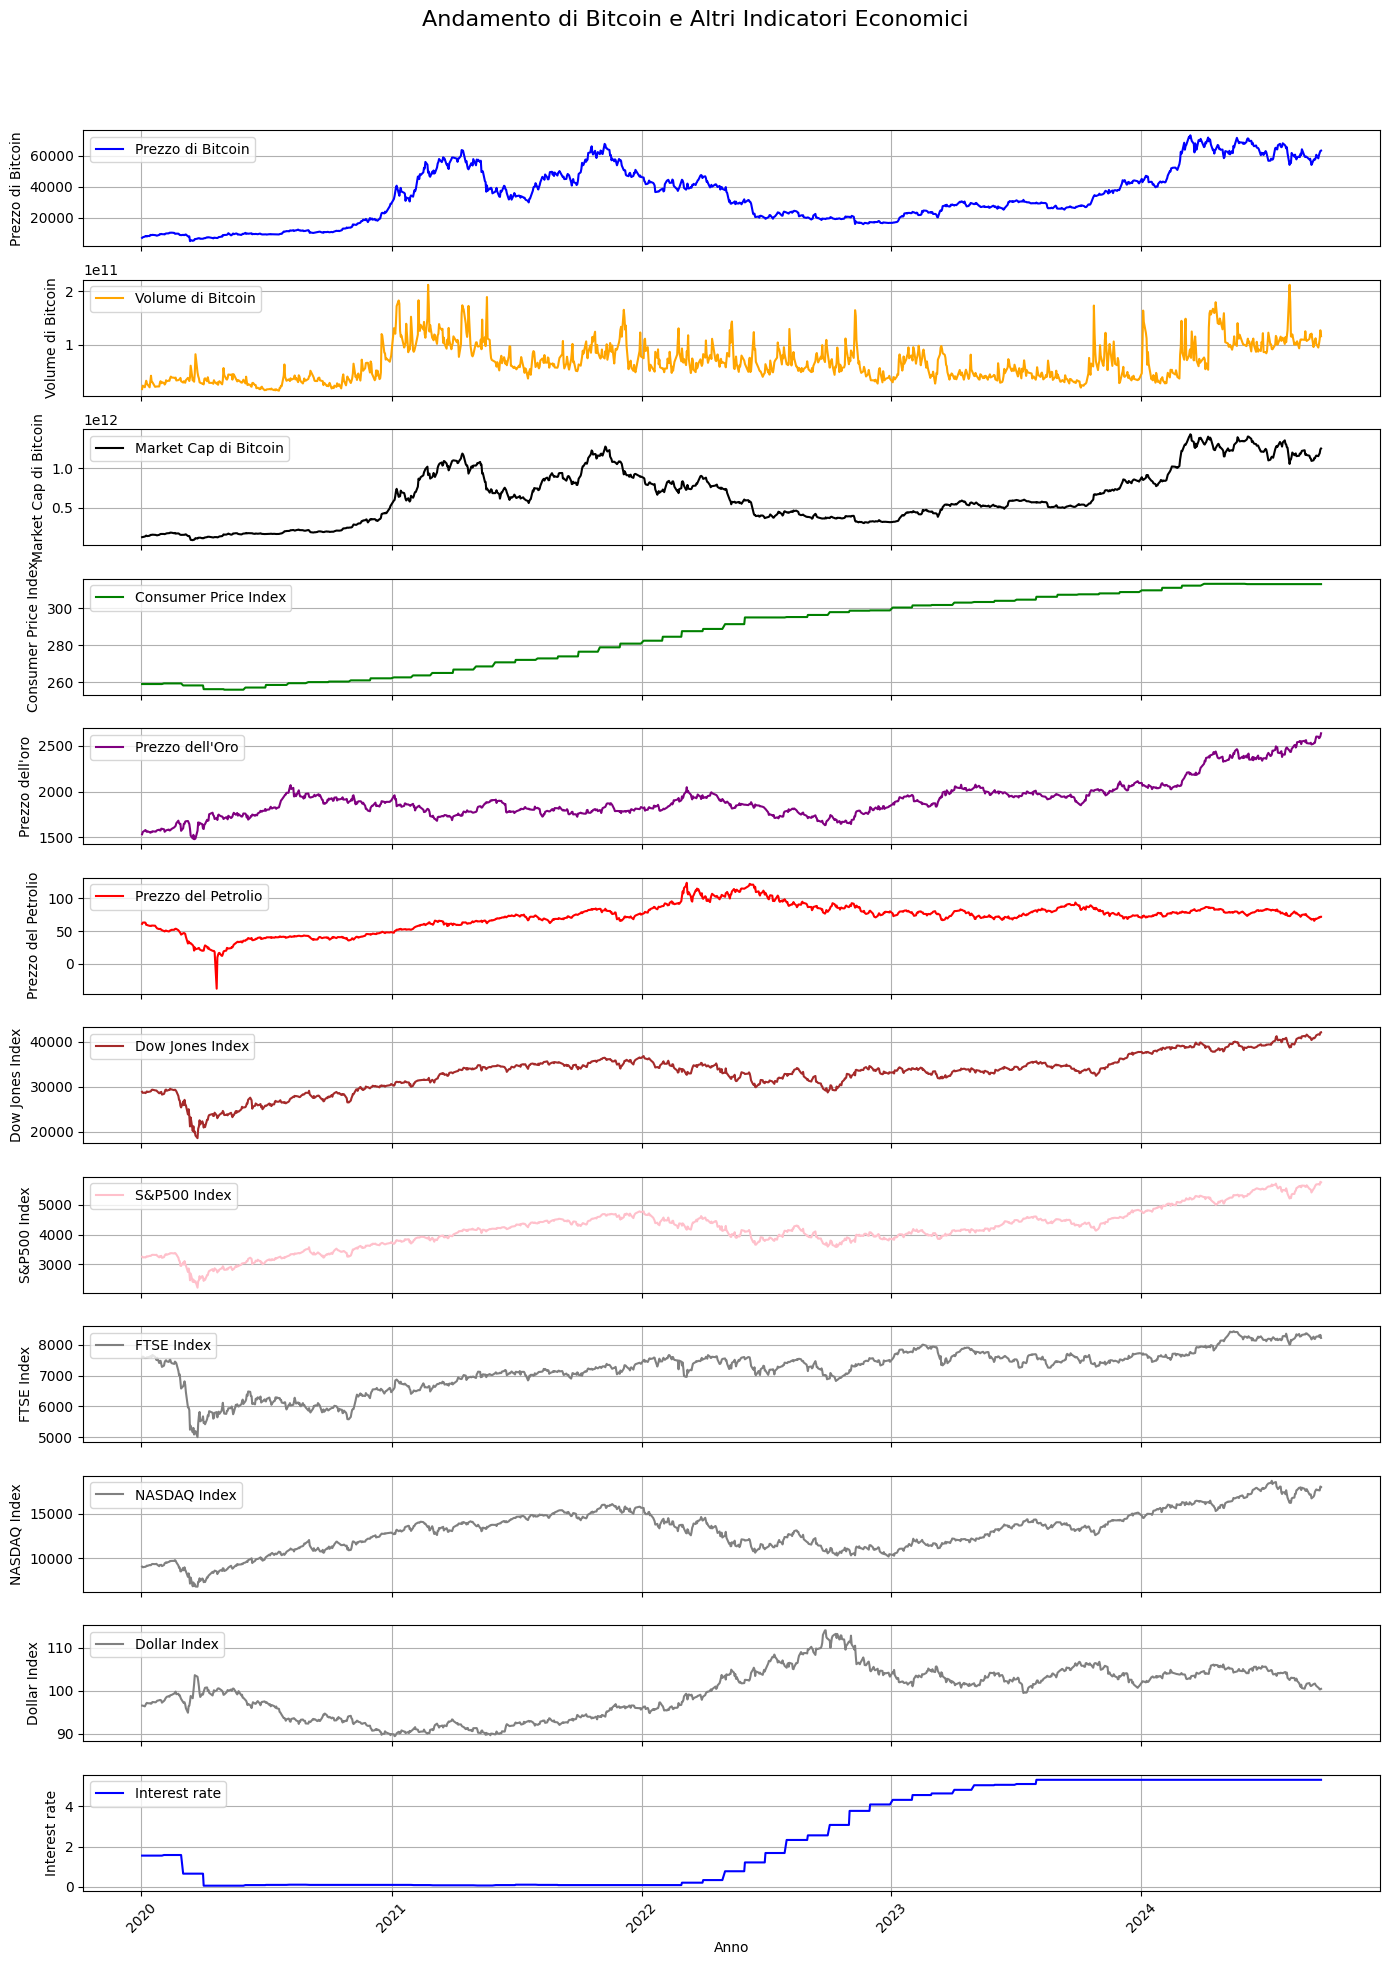

In [31]:
viz_data = price_df.set_index('Date')

fig, axs = plt.subplots(nrows=12, ncols=1, figsize=(14, 20), sharex=True)

#bitcoin
axs[0].plot(viz_data.index, viz_data['Price'], color='blue', label='Prezzo di Bitcoin')
axs[0].set_ylabel('Prezzo di Bitcoin')
axs[0].legend(loc='upper left')
axs[0].grid()

#volume di Bitcoin
axs[1].plot(viz_data.index, viz_data['volume'], color='orange', label='Volume di Bitcoin')
axs[1].set_ylabel('Volume di Bitcoin')
axs[1].legend(loc='upper left')
axs[1].grid()

#market cap di Bitcoin
axs[2].plot(viz_data.index, viz_data['market_cap'], color='black', label='Market Cap di Bitcoin')
axs[2].set_ylabel('Market Cap di Bitcoin')
axs[2].legend(loc='upper left')
axs[2].grid()

#cpi index
axs[3].plot(viz_data.index, viz_data['cpi_index'], color='green', label='Consumer Price Index')
axs[3].set_ylabel('Consumer Price Index')
axs[3].legend(loc='upper left')
axs[3].grid()

#gold price
axs[4].plot(viz_data.index, viz_data['gold_price'], color='purple', label="Prezzo dell'Oro")
axs[4].set_ylabel("Prezzo dell'oro")
axs[4].legend(loc='upper left')
axs[4].grid()

#oil price
axs[5].plot(viz_data.index, viz_data['oil_price'], color='red', label="Prezzo del Petrolio")
axs[5].set_ylabel("Prezzo del Petrolio")
axs[5].legend(loc='upper left')
axs[5].grid()

#dowjones index
axs[6].plot(viz_data.index, viz_data['dowjones_index'], color='brown', label='Dow Jones Index')
axs[6].set_ylabel('Dow Jones Index')
axs[6].legend(loc='upper left')
axs[6].grid()

#sp500 index
axs[7].plot(viz_data.index, viz_data['sp500_index'], color='pink', label='S&P500 Index')
axs[7].set_ylabel('S&P500 Index')
axs[7].legend(loc='upper left')
axs[7].grid()

#ftse index
axs[8].plot(viz_data.index, viz_data['ftse_index'], color='gray', label='FTSE Index')
axs[8].set_ylabel('FTSE Index')
axs[8].legend(loc='upper left')
axs[8].grid()

#nasdaq index
axs[9].plot(viz_data.index, viz_data['nasdaq_index'], color='gray', label='NASDAQ Index')
axs[9].set_ylabel('NASDAQ Index')
axs[9].legend(loc='upper left')
axs[9].grid()

#dollar index
axs[10].plot(viz_data.index, viz_data['dollar_index'], color='gray', label='Dollar Index')
axs[10].set_ylabel('Dollar Index')
axs[10].legend(loc='upper left')
axs[10].grid()

#interest_rate
axs[11].plot(viz_data.index, viz_data['interest_rate'], color='blue', label='Interest rate')
axs[11].set_ylabel('Interest rate')
axs[11].legend(loc='upper left')
axs[11].grid()

plt.xlabel('Anno')
plt.suptitle('Andamento di Bitcoin e Altri Indicatori Economici', fontsize=16)
plt.xticks(rotation=45)

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

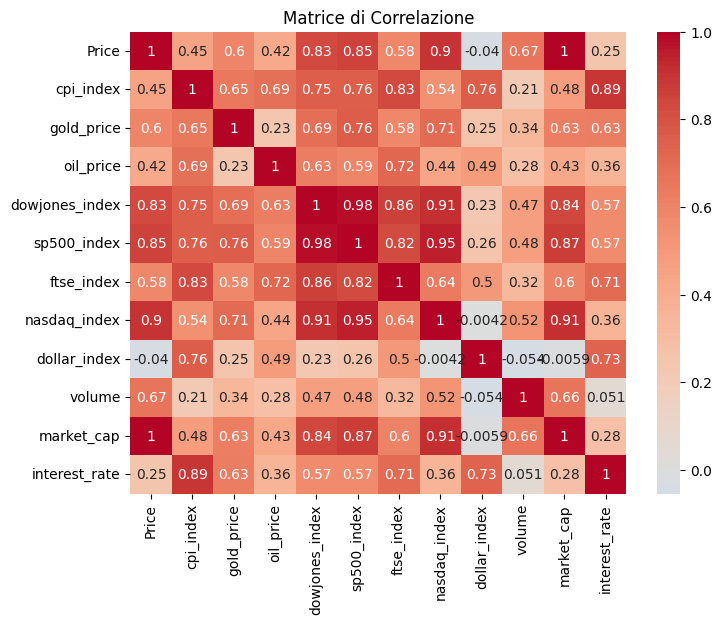

In [32]:
correlation_matrix = price_df[['Price','cpi_index', 'gold_price', 'oil_price', 'dowjones_index',
                                'sp500_index','ftse_index', 'nasdaq_index', 'dollar_index', 'volume', 'market_cap', 
                                'interest_rate']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matrice di Correlazione')
plt.show()

# 5. Modello LSTM

## 5.1 Normalizzazione dei dati

In [33]:
df_input = price_df[['Price','cpi_index', 'gold_price', 'oil_price', 'dowjones_index',
                     'sp500_index','ftse_index', 'nasdaq_index', 'dollar_index', 'volume', 'market_cap', 'interest_rate', 'Open', 'High', 'Low']]

df_input[['Price','cpi_index', 'gold_price', 'oil_price', 'dowjones_index',
                     'sp500_index']].describe()

,Price,cpi_index,gold_price,oil_price,dowjones_index,sp500_index
count,1163.000000,1163.000000,1163.000000,1163.000000,1163.00000,1163.000000
mean,33619.753224,286.417835,1914.573345,70.916285,33079.01675,4169.687842
std,18208.165359,20.267766,214.390685,20.692995,4174.33682,687.581523
min,4826.000000,255.848000,1480.600000,-37.630000,18591.93000,2220.500000
25%,19244.300000,264.910000,1780.700000,61.055000,30794.84500,3790.875000
50%,30097.800000,291.359000,1868.400000,74.370000,33761.05000,4172.750000
75%,46805.600000,304.628000,1989.200000,82.450000,35228.25000,4529.375000
max,73066.300000,313.225000,2634.600000,123.700000,42063.36000,5778.000000


In [34]:
df_input[['Price','cpi_index', 'gold_price', 'oil_price', 'dowjones_index',
                     'sp500_index','ftse_index', 'nasdaq_index', 'dollar_index', 'volume', 'market_cap', 'interest_rate']].describe()

,Price,cpi_index,gold_price,oil_price,dowjones_index,sp500_index,ftse_index,nasdaq_index,dollar_index,volume,market_cap,interest_rate
count,1163.000000,1163.000000,1163.000000,1163.000000,1163.00000,1163.000000,1163.000000,1163.000000,1163.000000,1.163000e+03,1.163000e+03,1163.000000
mean,33619.753224,286.417835,1914.573345,70.916285,33079.01675,4169.687842,7204.243766,13074.662631,99.608512,6.745754e+10,6.434649e+11,2.332158
std,18208.165359,20.267766,214.390685,20.692995,4174.33682,687.581523,675.223718,2365.492642,5.737221,3.485322e+10,3.547321e+11,2.324187
min,4826.000000,255.848000,1480.600000,-37.630000,18591.93000,2220.500000,4993.890000,6860.670000,89.409000,1.394019e+10,9.049935e+10,0.050000
25%,19244.300000,264.910000,1780.700000,61.055000,30794.84500,3790.875000,6921.705000,11358.675000,93.894000,3.924642e+10,3.664226e+11,0.090000
50%,30097.800000,291.359000,1868.400000,74.370000,33761.05000,4172.750000,7361.630000,13255.550000,100.910000,6.051732e+10,5.822839e+11,1.550000
75%,46805.600000,304.628000,1989.200000,82.450000,35228.25000,4529.375000,7618.455000,14682.835000,104.053000,8.930244e+10,8.878876e+11,5.120000
max,73066.300000,313.225000,2634.600000,123.700000,42063.36000,5778.000000,8445.800000,18647.450000,114.047000,2.121958e+11,1.428410e+12,5.330000


In [35]:
df_input[['ftse_index', 'nasdaq_index', 'dollar_index', 'volume', 'market_cap', 'interest_rate']].describe()

,ftse_index,nasdaq_index,dollar_index,volume,market_cap,interest_rate
count,1163.000000,1163.000000,1163.000000,1.163000e+03,1.163000e+03,1163.000000
mean,7204.243766,13074.662631,99.608512,6.745754e+10,6.434649e+11,2.332158
std,675.223718,2365.492642,5.737221,3.485322e+10,3.547321e+11,2.324187
min,4993.890000,6860.670000,89.409000,1.394019e+10,9.049935e+10,0.050000
25%,6921.705000,11358.675000,93.894000,3.924642e+10,3.664226e+11,0.090000
50%,7361.630000,13255.550000,100.910000,6.051732e+10,5.822839e+11,1.550000
75%,7618.455000,14682.835000,104.053000,8.930244e+10,8.878876e+11,5.120000
max,8445.800000,18647.450000,114.047000,2.121958e+11,1.428410e+12,5.330000


* Qui stai creando un’istanza di MinMaxScaler dalla libreria sklearn.preprocessing.
* Il MinMaxScaler è utilizzato per normalizzare i dati, riducendo ogni caratteristica in un intervallo specifico, di solito [0, 1].

In [36]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_input)

* Questo array conterrà i dati normalizzati, in modo che ogni colonna sia ridotta all’intervallo [0, 1].

In [37]:
data_scaled

array([[0.03137442, 0.05329662, 0.0465338 , ..., 0.03493696, 0.02691615,
        0.04493774],
       [0.03688583, 0.05329662, 0.06767764, ..., 0.03152898, 0.02974334,
        0.04468133],
       [0.04298193, 0.05329662, 0.08188908, ..., 0.03747024, 0.03530413,
        0.05183425],
       ...,
       [0.83428121, 0.99693257, 0.95875217, ..., 0.81307078, 0.82473278,
        0.82024755],
       [0.8515877 , 0.99693257, 0.97253033, ..., 0.83426152, 0.85533028,
        0.85560903],
       [0.85543586, 0.99693257, 1.        , ..., 0.85166187, 0.8587747 ,
        0.86703059]])

## 5.2 Preparazione dei dati

* features: contiene le caratteristiche (features) che userai come input nel tuo modello.
    * Prezzo di apertura (Open)
    * Prezzo massimo (High)
    * Prezzo minimo (Low)
    * Volume (Vol.)
    * Indice dei prezzi al consumo (CPI)
    * Prezzo dell’oro
    * Prezzo del petrolio
    * Indici di mercato (Dow Jones, S&P 500, FTSE, NASDAQ)
    * Indice del dollaro
    * Volume
    * Market cap
    * Interest rate
* target: contiene il valore che desideri prevedere, cioè il prezzo di Bitcoin.
    * Prezzo del Bitcoin

In [38]:
features = data_scaled # price, open, high, low, cpi_index, gold_price, oil_price, dowjones_index, sp500_index, ftse_index, nasdaq_index, dollar_index, volume, market cap, interest_rate
target = data_scaled[:,0] # price

* Il TimeseriesGenerator è uno strumento utile per preparare i dati delle serie temporali per l’addestramento di reti neurali ricorrenti. Prende sequenze di dati e genera batch di dati per l’addestramento.
    * features: I dati di input che vuoi utilizzare come caratteristiche per l’addestramento.
    * target: I valori target (etichette) che desideri prevedere.
    * length: Il numero di passaggi temporali precedenti da utilizzare come input per prevedere il passaggio temporale successivo. In questo caso, è impostato a 21.
    * sampling_rate: La frequenza con cui campionare i dati. Un valore di 1 significa che stai utilizzando ogni passaggio temporale nella sequenza.
    * batch_size: Il numero di campioni per ogni aggiornamento del gradiente, impostato a 1 qui.

In [39]:
TimeseriesGenerator(features, target, length=21, sampling_rate=1, batch_size=1)[0]

(array([[[0.03137442, 0.05329662, 0.0465338 , 0.61247133, 0.43784593,
          0.29191848, 0.75622192, 0.18932397, 0.28882214, 0.01532581,
          0.0283705 , 0.28409091, 0.03493696, 0.02691615, 0.04493774],
         [0.03688583, 0.05329662, 0.06767764, 0.62406248, 0.42787977,
          0.28531272, 0.76146539, 0.18326464, 0.28865979, 0.04733131,
          0.03001958, 0.28409091, 0.03152898, 0.02974334, 0.04468133],
         [0.04298193, 0.05329662, 0.08188908, 0.62542615, 0.43079821,
          0.28756149, 0.74783236, 0.18756607, 0.2817193 , 0.03251258,
          0.03421692, 0.28409091, 0.03747024, 0.03530413, 0.05183425],
         [0.04879375, 0.05329662, 0.08656846, 0.62189301, 0.42569839,
          0.28524245, 0.74740071, 0.18732088, 0.29600617, 0.06536179,
          0.03942316, 0.28409091, 0.04313312, 0.04113843, 0.05757616],
         [0.04738549, 0.05329662, 0.07443674, 0.60273973, 0.43257526,
          0.29226985, 0.74771358, 0.19246732, 0.30793896, 0.09397993,
          0.0436

* Questo è un passaggio cruciale nella preparazione dei dati per il modello LSTM per prevedere il prezzo di Bitcoin. La funzione train_test_split consente di dividere i dati in due o più sottoinsiemi casualmente.
    * features: Questo è il tuo array di input, che contiene i dati delle caratteristiche (ad esempio, il prezzo di Bitcoin, il volume, l’indice CPI, ecc.).
    * target: Questo è il tuo array di output, che contiene i valori che desideri prevedere (ad esempio, il prezzo futuro di Bitcoin).
    * test_size=0.20: Questo indica che il 20% dei dati sarà riservato per il set di test, mentre l’80% sarà utilizzato per l’addestramento.
    * random_state=123: Questo è un seme casuale per garantire che la suddivisione dei dati sia riproducibile. Usando lo stesso seme, otterrai la stessa divisione ogni volta che esegui il codice.
    * shuffle=False: Questo indica che i dati non devono essere mescolati prima della suddivisione. È importante mantenere l’ordine temporale dei dati quando si lavora con le serie temporali.

In [40]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=123, shuffle=False) # train data 80% e test data 20%

In [41]:
x_train.shape # 80% del dataframe

(930, 15)

In [42]:
x_test.shape # 20% del dataframe

(233, 15)

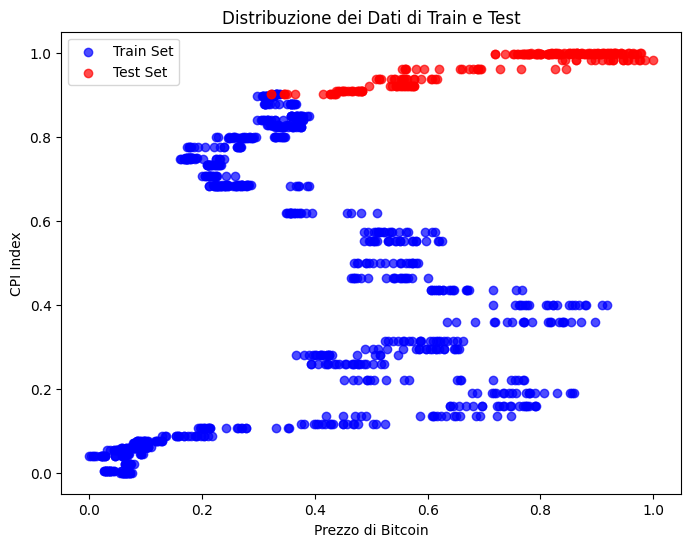

In [43]:
plt.figure(figsize=(8, 6))
plt.scatter(x_train[:, 0], x_train[:, 1], color='blue', label='Train Set', alpha=0.7)
plt.scatter(x_test[:, 0], x_test[:, 1], color='red', label='Test Set', alpha=0.7)
plt.title('Distribuzione dei Dati di Train e Test')
plt.xlabel('Prezzo di Bitcoin')
plt.ylabel('CPI Index')
plt.legend()
plt.show()

1. win_length=1: Questo parametro definisce la lunghezza della finestra temporale, ossia quanti passaggi temporali precedenti verranno utilizzati per prevedere il valore attuale. Impostandolo a 1, il modello utilizzerà solo il valore immediato precedente per fare una previsione.
2. batch_size=64: Questo parametro definisce il numero di campioni da elaborare in un batch. Ad esempio, se hai un batch_size di 64, il modello elaborerà 64 sequenze temporali alla volta. La scelta della dimensione del batch può influenzare le prestazioni del modello e la stabilità durante l’addestramento.
3. num_features=15: Questo parametro rappresenta il numero di caratteristiche che stai utilizzando nel tuo modello.

In [44]:
win_length=1
batch_size=64
num_features = 15
train_generator = TimeseriesGenerator(x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

## 5.2 Model Architecture

1. LSTM Layer:
    * LSTM(128, return_sequences=True): Questo strato ha 256 unità e restituisce la sequenza completa di output per ogni input (necessario per il secondo strato LSTM).
    * return_sequences=False nel terzo strato LSTM indica che restituirà solo l’output finale (adatto per problemi di regressione).
2. Leaky ReLU Activation:
    * LeakyReLU(alpha=0.5): Una funzione di attivazione che consente una piccola pendenza quando l’input è negativo, il che può aiutare a prevenire il problema dei neuroni “morti”.
3. Dropout:
    * Dropout(0.3): Questi strati aiutano a prevenire l’overfitting “disattivando” casualmente il 30% delle unità durante l’addestramento, rendendo il modello più robusto.
4. Dense Layer:
    * Dense(1): Lo strato finale ha un’unità, che produce il valore di previsione (prezzo di Bitcoin) come output.


In [45]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(256, input_shape=(win_length, num_features), return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.LSTM(256, return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.LSTM(256, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))

In [46]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 256)         │       278,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,329,409 (5.07 MB)

 Trainable params: 1,329,409 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

1. Il callback EarlyStopping interrompe l’addestramento quando la perdita di validazione (val_loss) non migliora per un numero specificato di epoche (in questo caso, 10 epoche). Questo può aiutare a risparmiare tempo di addestramento e ridurre il rischio di overfitting.
    * monitor='val_loss': Specifica che vogliamo monitorare la perdita di validazione.
    * patience=2: Il numero di epoche da attendere dopo il miglioramento prima di interrompere l’addestramento.
    * mode='min': Indica che stiamo cercando di minimizzare la perdita; quindi, se non ci sono miglioramenti in val_loss, l’addestramento si interromperà.
2. Compilazione del modello LSTM specificando la funzione di perdita, l’ottimizzatore e le metriche da utilizzare durante l’addestramento.
    * loss=tf.losses.MeanSquaredError(): La funzione di perdita MSE è adatta per la regressione e viene utilizzata per valutare quanto il modello prevede lontano dai valori reali.
    * optimizer=tf.optimizers.Adam(): L’ottimizzatore Adam è un’ottima scelta per l’addestramento dei modelli di deep learning e si adatta bene a molte applicazioni.
    * metrics=[tf.metrics.MeanAbsoluteError()]: Stai monitorando anche l’errore assoluto medio (MAE) come metrica durante l’addestramento, il che fornisce una comprensione aggiuntiva delle prestazioni del tuo modello.
3. Addestramento del modello.
    * epochs=50: Numero massimo di epoche di addestramento. Grazie a EarlyStopping, l’addestramento potrebbe fermarsi prima se non ci sono miglioramenti.
    * validation_data=test_generator: Specifica i dati di test per valutare il modello dopo ogni epoca.
    * shuffle=False: Imposta il parametro di shuffle a False poiché l’ordinamento delle serie temporali è importante e non deve essere mescolato.


In [47]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min')

model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])

history = model.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=False, callbacks=[early_stopping])

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.1064 - mean_absolute_error: 0.2264 - val_loss: 0.1015 - val_mean_absolute_error: 0.2878
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0352 - mean_absolute_error: 0.1685 - val_loss: 0.0742 - val_mean_absolute_error: 0.2437
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0568 - mean_absolute_error: 0.1906 - val_loss: 0.1167 - val_mean_absolute_error: 0.3178
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0237 - mean_absolute_error: 0.1375 - val_loss: 0.0069 - val_mean_absolute_error: 0.0675
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0218 - mean_absolute_error: 0.1324 - val_loss: 0.0114 - val_mean_absolute_error: 0.0984
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0092 - mean_absolute_error: 0.0860 - val_loss: 0.0201 - val_mean_absolute_error: 0.1369


Questo metodo calcola e restituisce le metriche specificate al momento della compilazione del modello (in questo caso, la perdita e l’errore assoluto medio).
L’output del metodo evaluate() fornirà due valori:
1.  Test Loss: La perdita totale del modello sui dati di test, che misura quanto le previsioni del modello si discostano dai valori reali. È la stessa funzione di perdita utilizzata durante l’addestramento (in questo caso, Mean Squared Error).
2.  Mean Absolute Error (MAE): Questa è una metrica che fornisce la media degli errori assoluti tra le previsioni e i valori reali, che può darti un’idea chiara della qualità delle previsioni del tuo modello.

In [48]:
loss, mae = model.evaluate(test_generator, verbose=0)

In [49]:
print(f"Errore quadratico medio (MSE): {loss}")
print(f"Errore medio assoluto (MAE): {mae}")

Errore quadratico medio (MSE): 0.02012523263692856
Errore medio assoluto (MAE): 0.13691644370555878


## 5.3 Previsioni

'predictions' utilizza il modello LSTM addestrato per generare previsioni sui dati di test.

In [50]:
predictions = model.predict(test_generator)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


In [51]:
predictions.shape[0]

232

In [52]:
x_test[:,1:][win_length:]

array([[0.90076163, 0.41637782, 0.77679291, ..., 0.32154458, 0.31804872,
        0.33813209],
       [0.90076163, 0.41013865, 0.77040848, ..., 0.32740672, 0.35980144,
        0.34460618],
       [0.90076163, 0.41143847, 0.77040848, ..., 0.34714402, 0.33989551,
        0.35908989],
       ...,
       [0.99693257, 0.95875217, 0.6727825 , ..., 0.81307078, 0.82473278,
        0.82024755],
       [0.99693257, 0.97253033, 0.67922891, ..., 0.83426152, 0.85533028,
        0.85560903],
       [0.99693257, 1.        , 0.67904296, ..., 0.85166187, 0.8587747 ,
        0.86703059]])

In [53]:
df_pred = pd.concat([pd.DataFrame(predictions), pd.DataFrame(x_test[:,1:][win_length:])], axis=1)
df_pred

,0,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.245388,0.900762,0.416378,0.776793,0.642413,0.600632,0.754860,0.555415,0.691006,0.075919,0.323481,1.0,0.321545,0.318049,0.338132
1,0.244523,0.900762,0.410139,0.770408,0.655802,0.612930,0.763850,0.569054,0.674771,0.163799,0.339414,1.0,0.327407,0.359801,0.344606
2,0.264657,0.900762,0.411438,0.770408,0.656361,0.613141,0.776764,0.566150,0.675258,0.309454,0.346443,1.0,0.347144,0.339896,0.359090
3,0.277254,0.900762,0.439775,0.780698,0.642191,0.596416,0.751500,0.547531,0.687759,0.192501,0.346666,1.0,0.345633,0.343808,0.360159
4,0.265946,0.900762,0.450260,0.787206,0.631501,0.585383,0.725871,0.536661,0.675258,0.149630,0.347835,1.0,0.344411,0.343922,0.360176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,0.675163,0.996933,0.967678,0.667700,0.981199,0.977864,0.951517,0.910466,0.458722,0.407367,0.793591,1.0,0.795748,0.787388,0.795304
228,0.666329,0.996933,0.953380,0.674518,0.980522,0.978145,0.960619,0.913514,0.452878,0.442502,0.808824,1.0,0.782370,0.818172,0.796822
229,0.681154,0.996933,0.958752,0.672782,0.976130,0.972453,0.944344,0.908868,0.441310,0.484747,0.820438,1.0,0.813071,0.824733,0.820248
230,0.700624,0.996933,0.972530,0.679229,0.998374,1.000000,0.966083,0.946256,0.442893,0.570452,0.857491,1.0,0.834262,0.855330,0.855609


Ripristino i dati scalati del DataFrame df_pred ai loro valori originali.

In [54]:
rev_trans = scaler.inverse_transform(df_pred)
rev_trans

array([[21571.38335804,   307.531     ,  1961.1       , ...,
        26761.1       , 27114.8       , 26682.9       ],
       [21512.3485507 ,   307.531     ,  1953.9       , ...,
        27161.2       , 29969.5       , 27119.7       ],
       [22886.25210981,   307.531     ,  1955.4       , ...,
        28508.3       , 28608.5       , 28096.9       ],
       ...,
       [51308.14196917,   313.049     ,  2587.        , ...,
        60308.5       , 61757.6       , 59210.7       ],
       [52636.81154093,   313.049     ,  2602.9       , ...,
        61754.8       , 63849.6       , 61596.5       ],
       [55135.17890479,   313.049     ,  2634.6       , ...,
        62942.4       , 64085.1       , 62367.1       ]])

In [55]:
df_final = df_input[predictions.shape[0]*-1:]

In [56]:
df_final['Previsione'] = rev_trans[:,0]
df_final

,Price,cpi_index,gold_price,oil_price,dowjones_index,sp500_index,ftse_index,nasdaq_index,dollar_index,volume,market_cap,interest_rate,Open,High,Low,Previsione
2257,26863.5,307.531,1961.1,87.69,33670.29,4357.25,7599.60,13407.23,106.434,2.899154e+10,5.232873e+11,5.33,26761.1,27114.8,26682.9,21571.383358
2258,28509.7,307.531,1953.9,86.66,33984.54,4401.00,7630.63,13567.98,106.034,4.641418e+10,5.446049e+11,5.33,27161.2,29969.5,27119.7,21512.348551
2259,28403.6,307.531,1955.4,86.66,33997.65,4401.75,7675.21,13533.75,106.046,7.529127e+10,5.540096e+11,5.33,28508.3,28608.5,28096.9,22886.252110
2260,28321.7,307.531,1988.1,88.32,33665.08,4342.25,7588.00,13314.30,106.354,5.210462e+10,5.543076e+11,5.33,28405.2,28876.0,28169.0,23745.866668
2261,28723.0,307.531,2000.2,89.37,33414.17,4303.00,7499.53,13186.17,106.046,4.360509e+10,5.558713e+11,5.33,28321.8,28883.8,28170.2,22974.208441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2484,58213.1,313.049,2597.3,70.09,41622.08,5699.25,8278.44,17592.13,100.711,9.470302e+10,1.152253e+12,5.33,59126.2,59204.3,57527.8,50899.323691
2485,60309.1,313.049,2580.8,71.19,41606.18,5700.25,8309.86,17628.06,100.567,1.016688e+11,1.172633e+12,5.33,58213.1,61309.0,57630.2,50296.492648
2486,61757.6,313.049,2587.0,70.91,41503.10,5680.00,8253.68,17573.30,100.282,1.100440e+11,1.188172e+12,5.33,60308.5,61757.6,59210.7,51308.141969
2487,62938.6,313.049,2602.9,71.95,42025.19,5778.00,8328.72,18013.98,100.321,1.270354e+11,1.237745e+12,5.33,61754.8,63849.6,61596.5,52636.811541


In [57]:
df_final = df_final.rename(columns={'Price': 'Bitcoin valore reale', 'Previsione': 'Bitcoin valore predetto'})
print(df_final[['Bitcoin valore reale', 'Bitcoin valore predetto']])

      Bitcoin valore reale  Bitcoin valore predetto
2257               26863.5             21571.383358
2258               28509.7             21512.348551
2259               28403.6             22886.252110
2260               28321.7             23745.866668
2261               28723.0             22974.208441
...                    ...                      ...
2484               58213.1             50899.323691
2485               60309.1             50296.492648
2486               61757.6             51308.141969
2487               62938.6             52636.811541
2488               63201.2             55135.178905

[232 rows x 2 columns]


In [58]:
mae = mean_absolute_error(df_final['Bitcoin valore reale'], df_final['Bitcoin valore predetto'])
mse = mean_squared_error(df_final['Bitcoin valore reale'], df_final['Bitcoin valore predetto'])
rmse = mean_squared_error(df_final['Bitcoin valore reale'], df_final['Bitcoin valore predetto'], squared=False)
mape = mean_absolute_percentage_error(df_final['Bitcoin valore reale'], df_final['Bitcoin valore predetto'])
r2 = r2_score(df_final['Bitcoin valore reale'], df_final['Bitcoin valore predetto'])

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Percentage Error: {mape}')
print(f'R-Squared: {r2}')

Mean Absolute Error: 9343.219666246996
Mean Squared Error: 93717944.51055072
Root Mean Squared Error: 9680.802885636642
Mean Absolute Percentage Error: 0.17418511107495352
R-Squared: 0.3856998574956515


<Figure size 3000x1800 with 0 Axes>

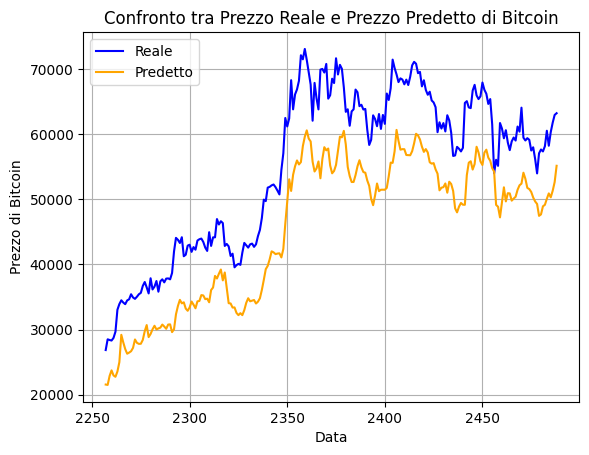

In [59]:
plt.figure(figsize=(30, 18))
df_final[['Bitcoin valore reale', 'Bitcoin valore predetto']].plot(color=['blue', 'orange'])
plt.title('Confronto tra Prezzo Reale e Prezzo Predetto di Bitcoin')
plt.xlabel('Data')
plt.ylabel('Prezzo di Bitcoin')
plt.legend(['Reale', 'Predetto'])
plt.grid()
plt.show()

In [60]:
import plotly.graph_objects as go

# Definisci i nomi degli strati e le posizioni
layers = ['Input Layer', 'LSTM Layer', 'Dropout Layer', 'Dense Layer', 'Output Layer']
positions = [1, 2, 3, 4, 5]

# Crea un diagramma di flusso usando Plotly
fig = go.Figure()

# Aggiungi gli strati come nodi
for i, layer in enumerate(layers):
    fig.add_trace(go.Scatter(
        x=[positions[i]], y=[0],
        text=[layer],
        mode='markers+text',
        textposition='bottom center',
        marker=dict(size=40, color='skyblue', line=dict(width=2, color='blue'))
    ))

# Aggiungi le frecce tra i nodi per mostrare il flusso
for i in range(len(positions) - 1):
    fig.add_annotation(
        x=positions[i + 1], y=0, ax=positions[i], ay=0,
        xref='x', yref='y', axref='x', ayref='y',
        showarrow=True, arrowhead=2, arrowsize=1, arrowwidth=2, arrowcolor='blue'
    )

# Configura il layout
fig.update_layout(
    title='Architettura del Modello LSTM',
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False),
    showlegend=False,
    width=800, height=400
)

fig.show()

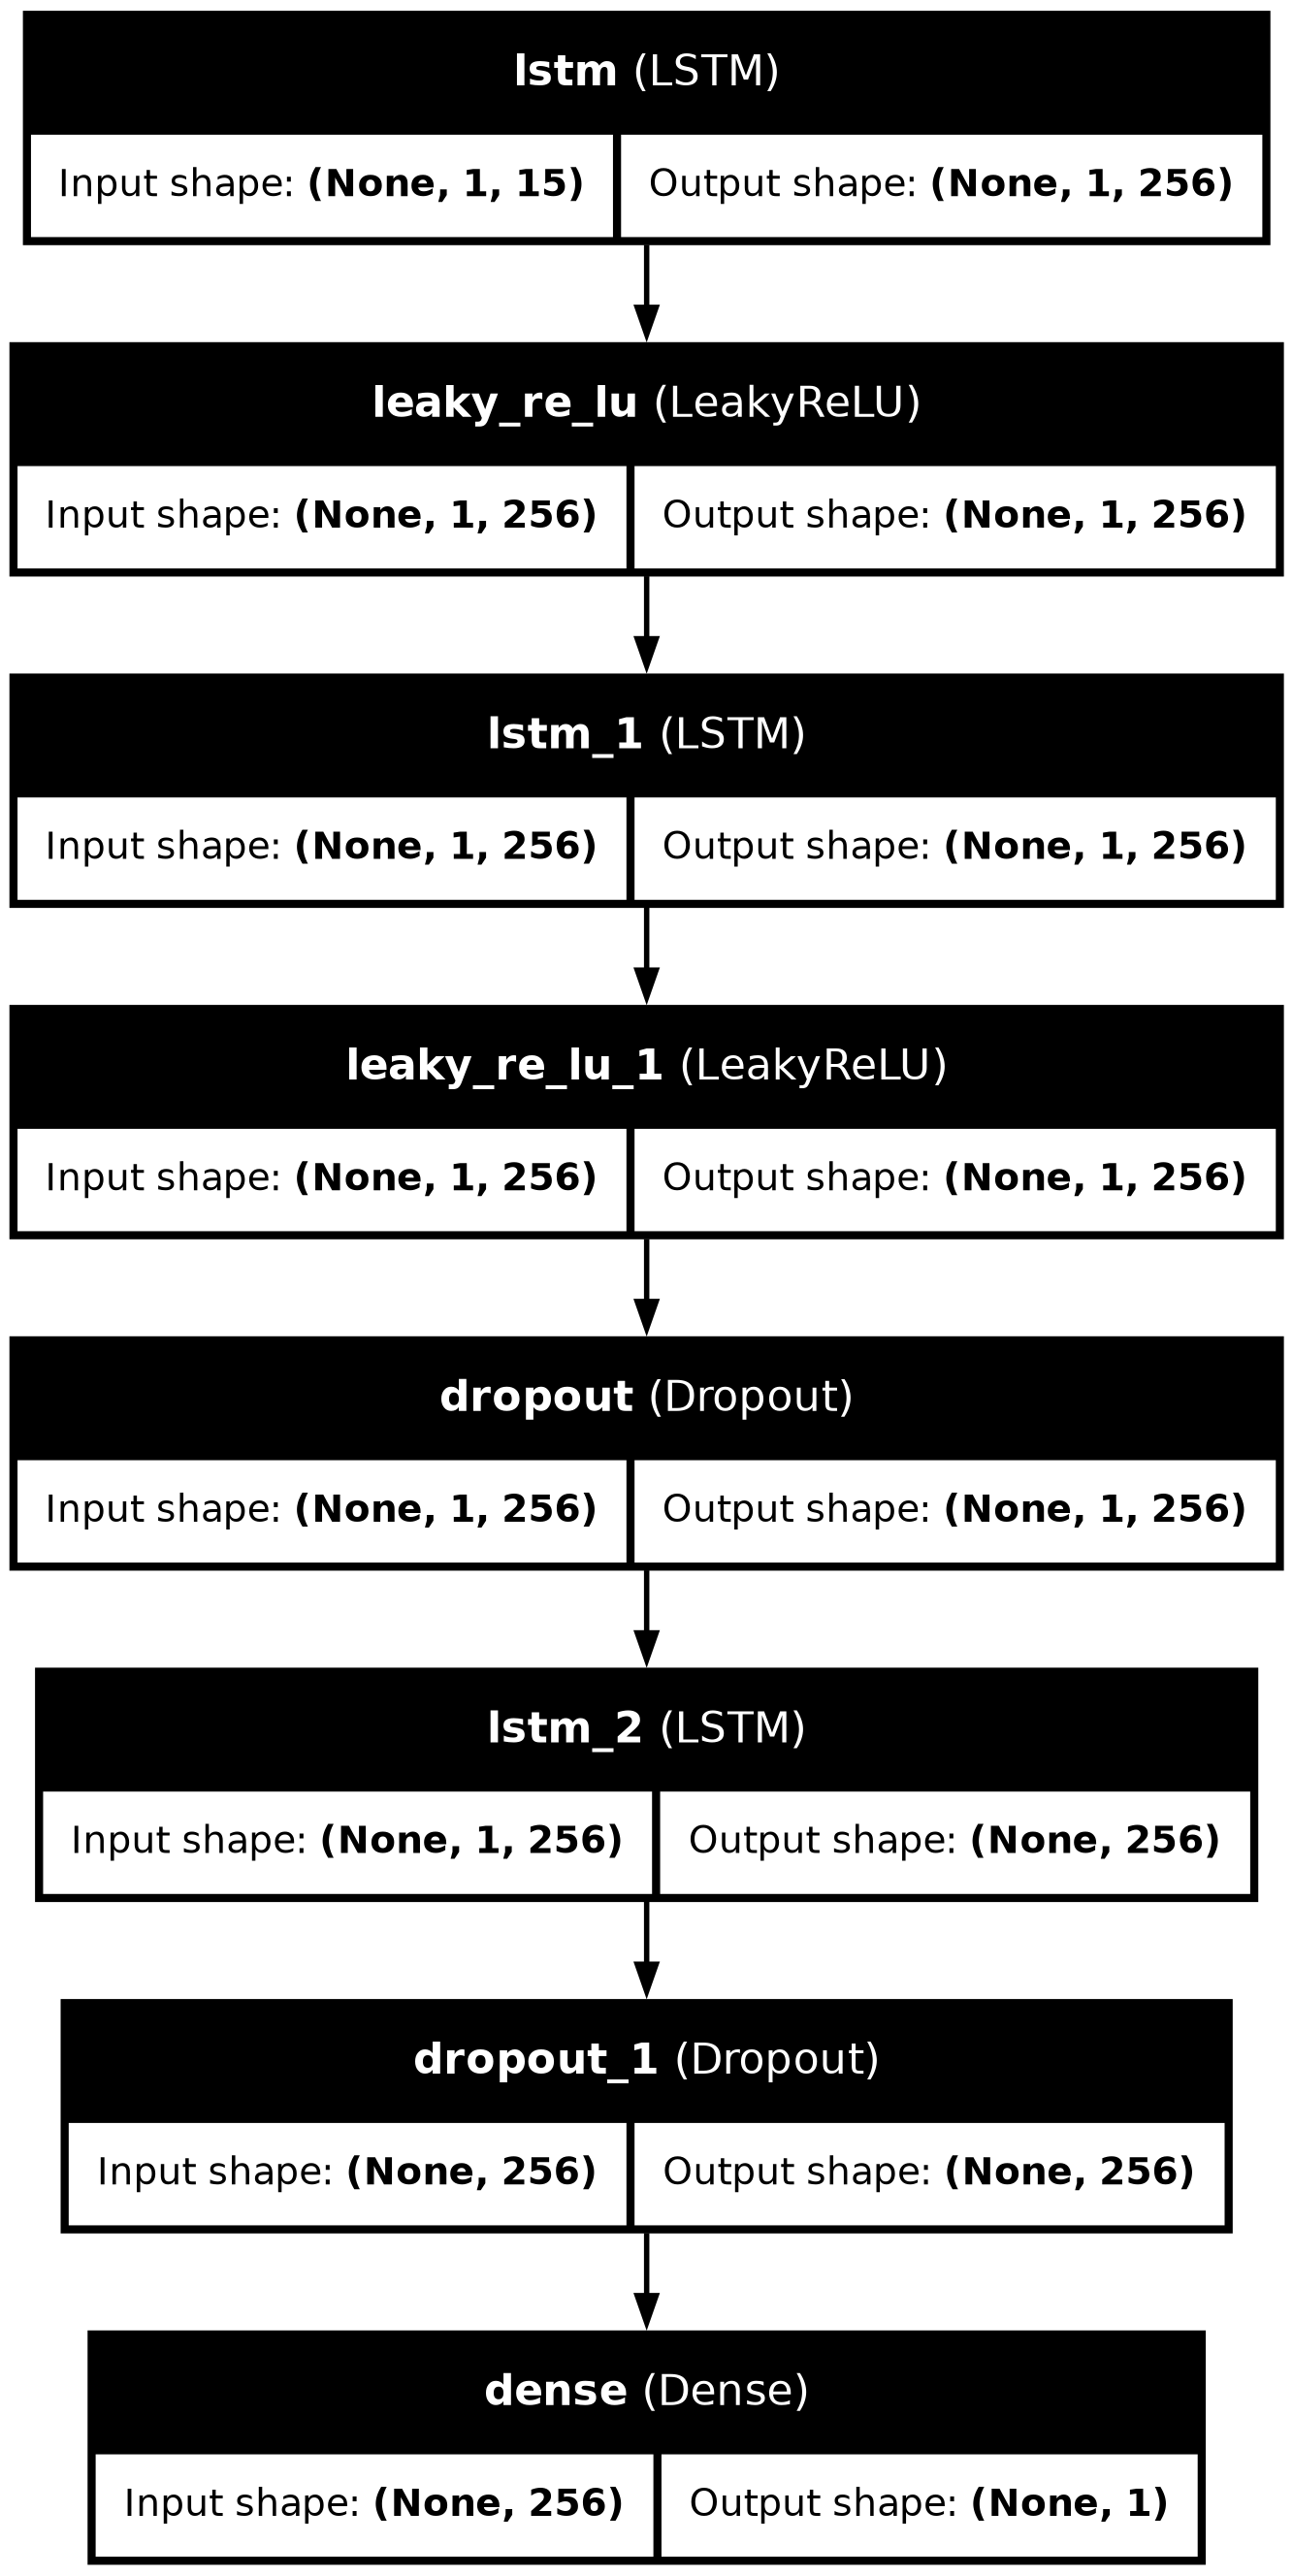

In [61]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='lstm_model_architecture.png', show_shapes=True, show_layer_names=True)